Best Parameters: [6.51819444e+01 1.75866433e-02]
Best Hidden Size: 65
Best Learning Rate: 0.017586643258813248


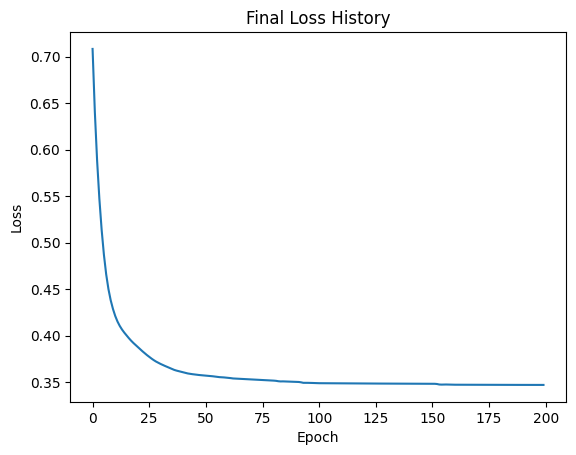

Final Test Accuracy: 0.8150


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

def differential_evolution(fitness_function, bounds, population_size, generations, mutation_factor, crossover_probability):
    num_dimensions = len(bounds)
    population = np.random.rand(population_size, num_dimensions)
    for i in range(num_dimensions):
        population[:, i] = bounds[i][0] + population[:, i] * (bounds[i][1] - bounds[i][0])

    for generation in range(generations):
        for i in range(population_size):
            indices = [idx for idx in range(population_size) if idx != i]
            a, b, c = population[np.random.choice(indices, 3, replace=False)]
            mutant_vector = a + mutation_factor * (b - c)
            mutant_vector = np.clip(mutant_vector, [b[0] for b in bounds], [b[1] for b in bounds])

            trial_vector = np.copy(population[i])
            for j in range(num_dimensions):
                if np.random.rand() < crossover_probability:
                    trial_vector[j] = mutant_vector[j]

            if fitness_function(trial_vector) < fitness_function(population[i]):
                population[i] = trial_vector

    best_index = np.argmin([fitness_function(ind) for ind in population])
    return population[best_index]

def fitness_function(params):
    hidden_size = int(params[0])
    learning_rate = params[1]

    model = SimpleNN(input_size=20, hidden_size=hidden_size, output_size=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []
    model.train()
    for epoch in range(10):  # 10 epochs for trials (also should be investigated)
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).float().mean().item()

    # Plot loss history for the current configuration
    #plt.plot(loss_history)
    #plt.title(f"Loss History (Hidden Size: {hidden_size}, LR: {learning_rate:.5f})")
    #plt.xlabel("Epoch")
    #plt.ylabel("Loss")
    #plt.show()

    return 1 - accuracy  # Minimize 1 - accuracy

# Hyperparameter bounds
bounds = [
    (4, 128),  # hidden_size
    (1e-4, 1e-1)  # learning_rate
]

# Run the differential evolution algorithm
best_params = differential_evolution(fitness_function, bounds, population_size=20, generations=100, mutation_factor=0.8, crossover_probability=0.7)

print("Best Parameters:", best_params)
print("Best Hidden Size:", int(best_params[0]))
print("Best Learning Rate:", best_params[1])

# Evaluate final model with best parameters
hidden_size = int(best_params[0])
learning_rate = best_params[1]
model = SimpleNN(input_size=20, hidden_size=hidden_size, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop for the best model
loss_history = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

# Final evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).float().mean().item()

# Plot final loss history
plt.plot(loss_history)
plt.title("Final Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print(f"Final Test Accuracy: {accuracy:.4f}")
